In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from post_processing import *
from utils import *
from fast_macro_f1_func import *

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
# chris clean dataset
df_train = pd.read_csv("../input/train_clean.csv")
df_test = pd.read_csv("../input/test_clean.csv")

df_train["local_time"] = df_train.time % 50
df_train.loc[df_train.local_time == 0.0000, "local_time"] = 50

df_test["local_time"] = df_test.time % 50
df_test.loc[df_test.local_time == 0.0000, "local_time"] = 50

df_test["mini_local_time"] = df_test.time % 10
df_test.loc[df_test.local_time == 0.0000, "mini_local_time"] = 10

BATCH_SIZE = 500000

# train
for batch_i in range(10):
    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
# test
for batch_i in range(4):
    df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_test.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_test.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_test.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_test.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5

In [3]:
# channel 0 - batch 1
channel_0_batch_1 = df_train[(df_train.batch == 1) & (df_train.open_channels == 0)]
channel_0_batch_1_threshold = channel_0_batch_1.signal.quantile(0.99999)
channel_0_batch_1.loc[channel_0_batch_1.signal > channel_0_batch_1_threshold, "signal"] = channel_0_batch_1_threshold
df_train.loc[(df_train.batch == 1) & (df_train.open_channels == 0), "signal"] = channel_0_batch_1.signal

In [4]:
shift_val = 2.726
df_train.loc[(df_train.batch.isin([5, 10])), "signal"] += shift_val
df_test.loc[(df_test.batch.isin([2])) & (df_test.mini_batch.isin([1, 3])),
            "signal"] += shift_val

In [5]:
# df_train = pd.read_pickle('../features/train_v2.pkl')
# df_test = pd.read_pickle('../features/test_v2.pkl')

sub = pd.read_csv("../input/sample_submission.csv")
sub['time'] = [format(sub.time.values[x], '.4f') for x in range(2000000)]
TARGET = "open_channels"

print(df_train.shape, df_test.shape, sub.shape)
df_train.head()

(5000000, 6) (2000000, 6) (2000000, 2)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [21]:
import pywt
def denoise_signal_simple(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x["signal"], wavelet, mode="constant")
    #univeral threshold
    uthresh = level
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    x[f"signal_fil_{level}"] = pywt.waverec(coeff, wavelet, mode='constant')
    return x

# den_sample_simple = denoise_signal_simple(sig.signal)
# print(sig.signal.values[:5])
# print(den_sample_simple[:5].round(4))
# plt.plot(sig.signal)
# plt.plot(den_sample_simple)
level=1
df_train["signal_fil"] = denoise_signal_simple(df_train)[f"signal_fil_{level}"]
df_test["signal_fil"] = denoise_signal_simple(df_test)[f"signal_fil_{level}"]

In [17]:
level = 10
df_train[f"signal_fil_{level}"] = df_train.groupby(["batch"]).apply(denoise_signal_simple, level=level)[f"signal_fil_{level}"]

In [18]:
df_train.head()

,time,signal,open_channels,local_time,batch,mini_batch,signal_fil_1,signal_fil,signal_fil_10
0,0.0001,-2.7600,0,0.0001,1.0,1.0,-2.698278,-2.698278,-2.70447
1,0.0002,-2.8557,0,0.0002,1.0,1.0,-2.698278,-2.698278,-2.70447
2,0.0003,-2.4074,0,0.0003,1.0,1.0,-2.698278,-2.698278,-2.70447
3,0.0004,-3.1404,0,0.0004,1.0,1.0,-2.698278,-2.698278,-2.70447
4,0.0005,-3.1525,0,0.0005,1.0,1.0,-2.698278,-2.698278,-2.70447


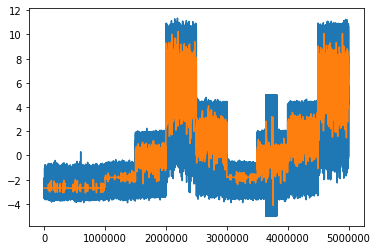

In [19]:
plt.plot(df_train.signal)
plt.plot(df_train[f"signal_fil_{level}"])

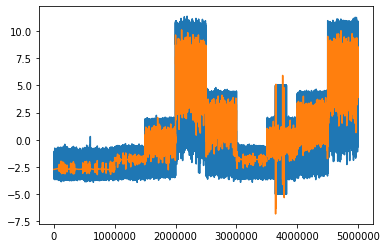

In [15]:
plt.plot(df_train.signal)
plt.plot(df_train[f"signal_fil_{level}"])